In [1]:
from utils.config_loader import load_config, assign_config
from processing.climatology import process_climatology
from processing.preprocessing import preprocess_data
from processing.normalize import normalize_data
from model.train import train_model
from model.inference import infer, infer_future
from model.metrics import weighted_rmse, weighted_rmse_acc_future
from visualization.plots import plot_heatmaps

config = load_config("./config/params.yaml")

Login to wandb and init experiment

In [ ]:
import wandb
import os

os.environ['WANDB_NOTEBOOK_NAME'] = "pipeline.ipynb"
wandb.login()

run = wandb.init(
    project="WindViVit2",
    
    notes="Patch recovery",
    tags=["17 years data", "LinearLR", "BERT Large", "Patch recovery"]
)

wandb_config = wandb.config

assign_config(wandb_config, config)

### Data preprocessing

In [ ]:
process_climatology(config)

In [ ]:
preprocess_data(config)

In [ ]:
normalize_data(config)

### Training

In [ ]:
train_model(config)

### Evaluate model

In [2]:
results = infer(config)

In [ ]:
rmse_surface, rmse_upper = weighted_rmse(config, results, 12)
wandb.log({"upper_rmse": rmse_upper, "surface_rmse": rmse_surface})
print(rmse_surface)
print(rmse_upper)

In [2]:
results_future = infer_future(config, 12)

In [4]:
import json

results = {}

for i in range(2):
    rmse_surface, rmse_upper, acc_surface, acc_upper = weighted_rmse_acc_future(config, results_future, i)
    results[i] = {"upper_rmse": rmse_upper, "surface_rmse": rmse_surface, "upper_acc": acc_upper, "surface_acc": acc_surface}

# Guardar los resultados en un archivo JSON
with open('metrics.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)

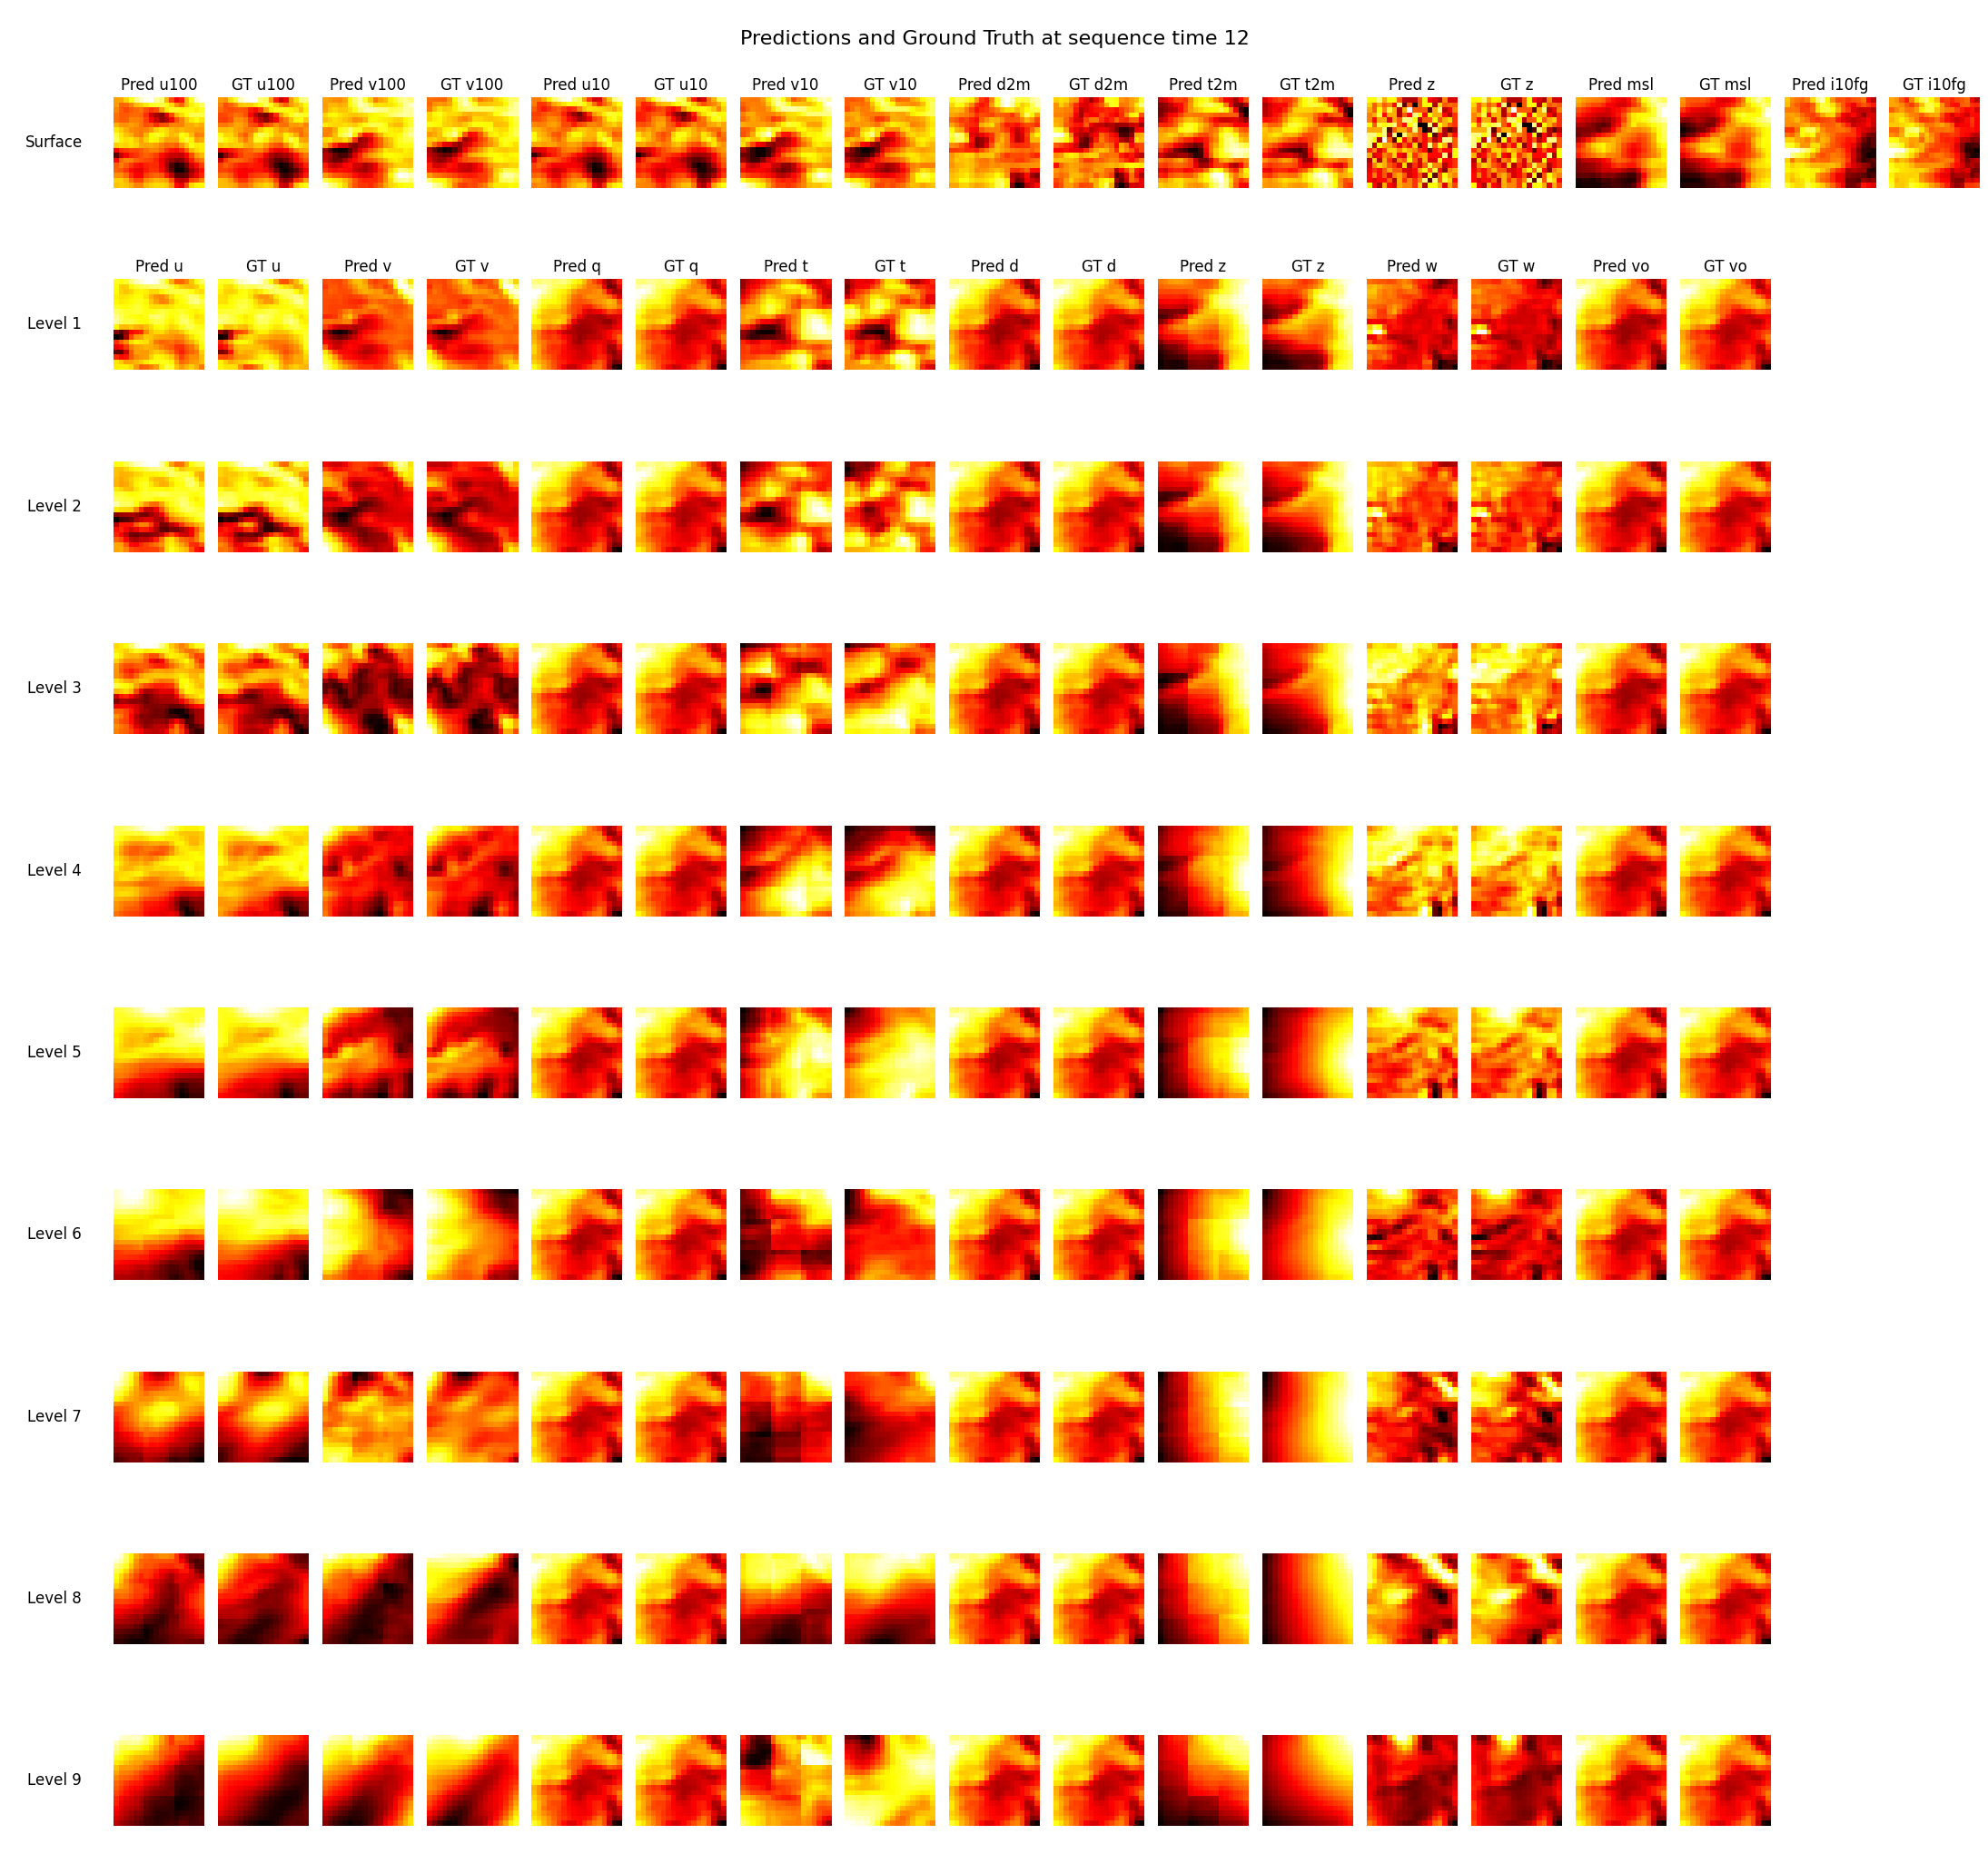

<Figure size 640x480 with 0 Axes>

In [3]:
fig = plot_heatmaps(config, results, 11)

In [13]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_heatmaps2(config: dict, results: list, seq=5):
    """
    Plots heatmaps of predictions and ground truth for both upper and surface variables for a given sequence index.
    
    Parameters:
    - config (dict): Dictionary containing the configuration settings.
    - results (list): List of dictionaries containing the predictions and ground truth.
    - seq (int): Sequence index to plot.
    """

    plot_path = os.path.join(config["global"]["path"], config["global"]["reports_path"])

    upper_var_names = config["preprocessing"]["upper_var_names"][1:]
    pressure_levels_upper = config["preprocessing"]["limits"]["levels"][1]
    surface_var_names = config["preprocessing"]["surface_var_names"][1:]
    
    nrows = pressure_levels_upper + 1
    ncols = max(len(upper_var_names), len(surface_var_names)) * 2 + 1
    
    fig = plt.figure(figsize=(20 + 2, 2 * nrows + 1))
    gs = GridSpec(nrows, ncols, figure=fig)
    
    # Plot surface variables
    surface_result = next((r for r in results if r['type'] == 'surface'), None)
    if surface_result:
        for var_index, var_name in enumerate(surface_var_names):
            ax_pred = fig.add_subplot(gs[0, var_index * 2 + 1])
            ax_gt = fig.add_subplot(gs[0, var_index * 2 + 2])
            
            prediction = surface_result['prediction'][seq, :, :, var_index]
            ground_truth = surface_result['ground_truth'][seq, :, :, var_index]
            
            ax_pred.imshow(prediction, cmap='hot', interpolation='nearest')
            ax_pred.axis('off')
            ax_gt.imshow(ground_truth, cmap='hot', interpolation='nearest')
            ax_gt.axis('off')
            
            # Save each subplot
            pred_fig, pred_ax = plt.subplots()
            pred_ax.imshow(prediction, cmap='hot', interpolation='nearest')
            pred_ax.axis('off')
            pred_fig.savefig(os.path.join(plot_path, f'Pred_{var_name}_seq_{seq+1}.png'), bbox_inches='tight', pad_inches=0)
            plt.close(pred_fig)

            gt_fig, gt_ax = plt.subplots()
            gt_ax.imshow(ground_truth, cmap='hot', interpolation='nearest')
            gt_ax.axis('off')
            gt_fig.savefig(os.path.join(plot_path, f'GT_{var_name}_seq_{seq+1}.png'), bbox_inches='tight', pad_inches=0)
            plt.close(gt_fig)
                
        ax_surface = fig.add_subplot(gs[0, 0])
        ax_surface.text(0.5, 0.5, "Surface", fontsize=12, ha='center', va='center')
        ax_surface.axis('off')
    else:
        print("Surface results not found.")

    # Plot upper variables
    upper_result = next((r for r in results if r['type'] == 'upper'), None)
    if upper_result:
        for level in range(pressure_levels_upper):
            for var_index, var_name in enumerate(upper_var_names):
                ax_pred = fig.add_subplot(gs[level + 1, var_index * 2 + 1])
                ax_gt = fig.add_subplot(gs[level + 1, var_index * 2 + 2])
                
                prediction = upper_result['prediction'][seq, level, :, :, var_index]
                ground_truth = upper_result['ground_truth'][seq, level, :, :, var_index]
                
                ax_pred.imshow(prediction, cmap='hot', interpolation='nearest')
                ax_pred.axis('off')
                ax_gt.imshow(ground_truth, cmap='hot', interpolation='nearest')
                ax_gt.axis('off')
                
                # Save each subplot
                pred_fig, pred_ax = plt.subplots()
                pred_ax.imshow(prediction, cmap='hot', interpolation='nearest')
                pred_ax.axis('off')
                pred_fig.savefig(os.path.join(plot_path, f'Pred_{var_name}_Level_{level+1}_seq_{seq+1}.png'), bbox_inches='tight', pad_inches=0)
                plt.close(pred_fig)

                gt_fig, gt_ax = plt.subplots()
                gt_ax.imshow(ground_truth, cmap='hot', interpolation='nearest')
                gt_ax.axis('off')
                gt_fig.savefig(os.path.join(plot_path, f'GT_{var_name}_Level_{level+1}_seq_{seq+1}.png'), bbox_inches='tight', pad_inches=0)
                plt.close(gt_fig)
                    
            ax_level = fig.add_subplot(gs[level + 1, 0])
            ax_level.text(0.5, 0.5, f'Level {level + 1}', fontsize=12, ha='center', va='center')
            ax_level.axis('off')
    else:
        print("Upper results not found.")
    
    plt.suptitle(f'\nPredictions and Ground Truth at sequence time {seq+1}\n', fontsize=16)
    plt.tight_layout()
    plt.show()

    if config["plots"]["pred_vs_true"]:
        plt.savefig(os.path.join(plot_path, f'{config["train"]["model_name"]}_heatmaps_{seq+1}.png'))

    return fig


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

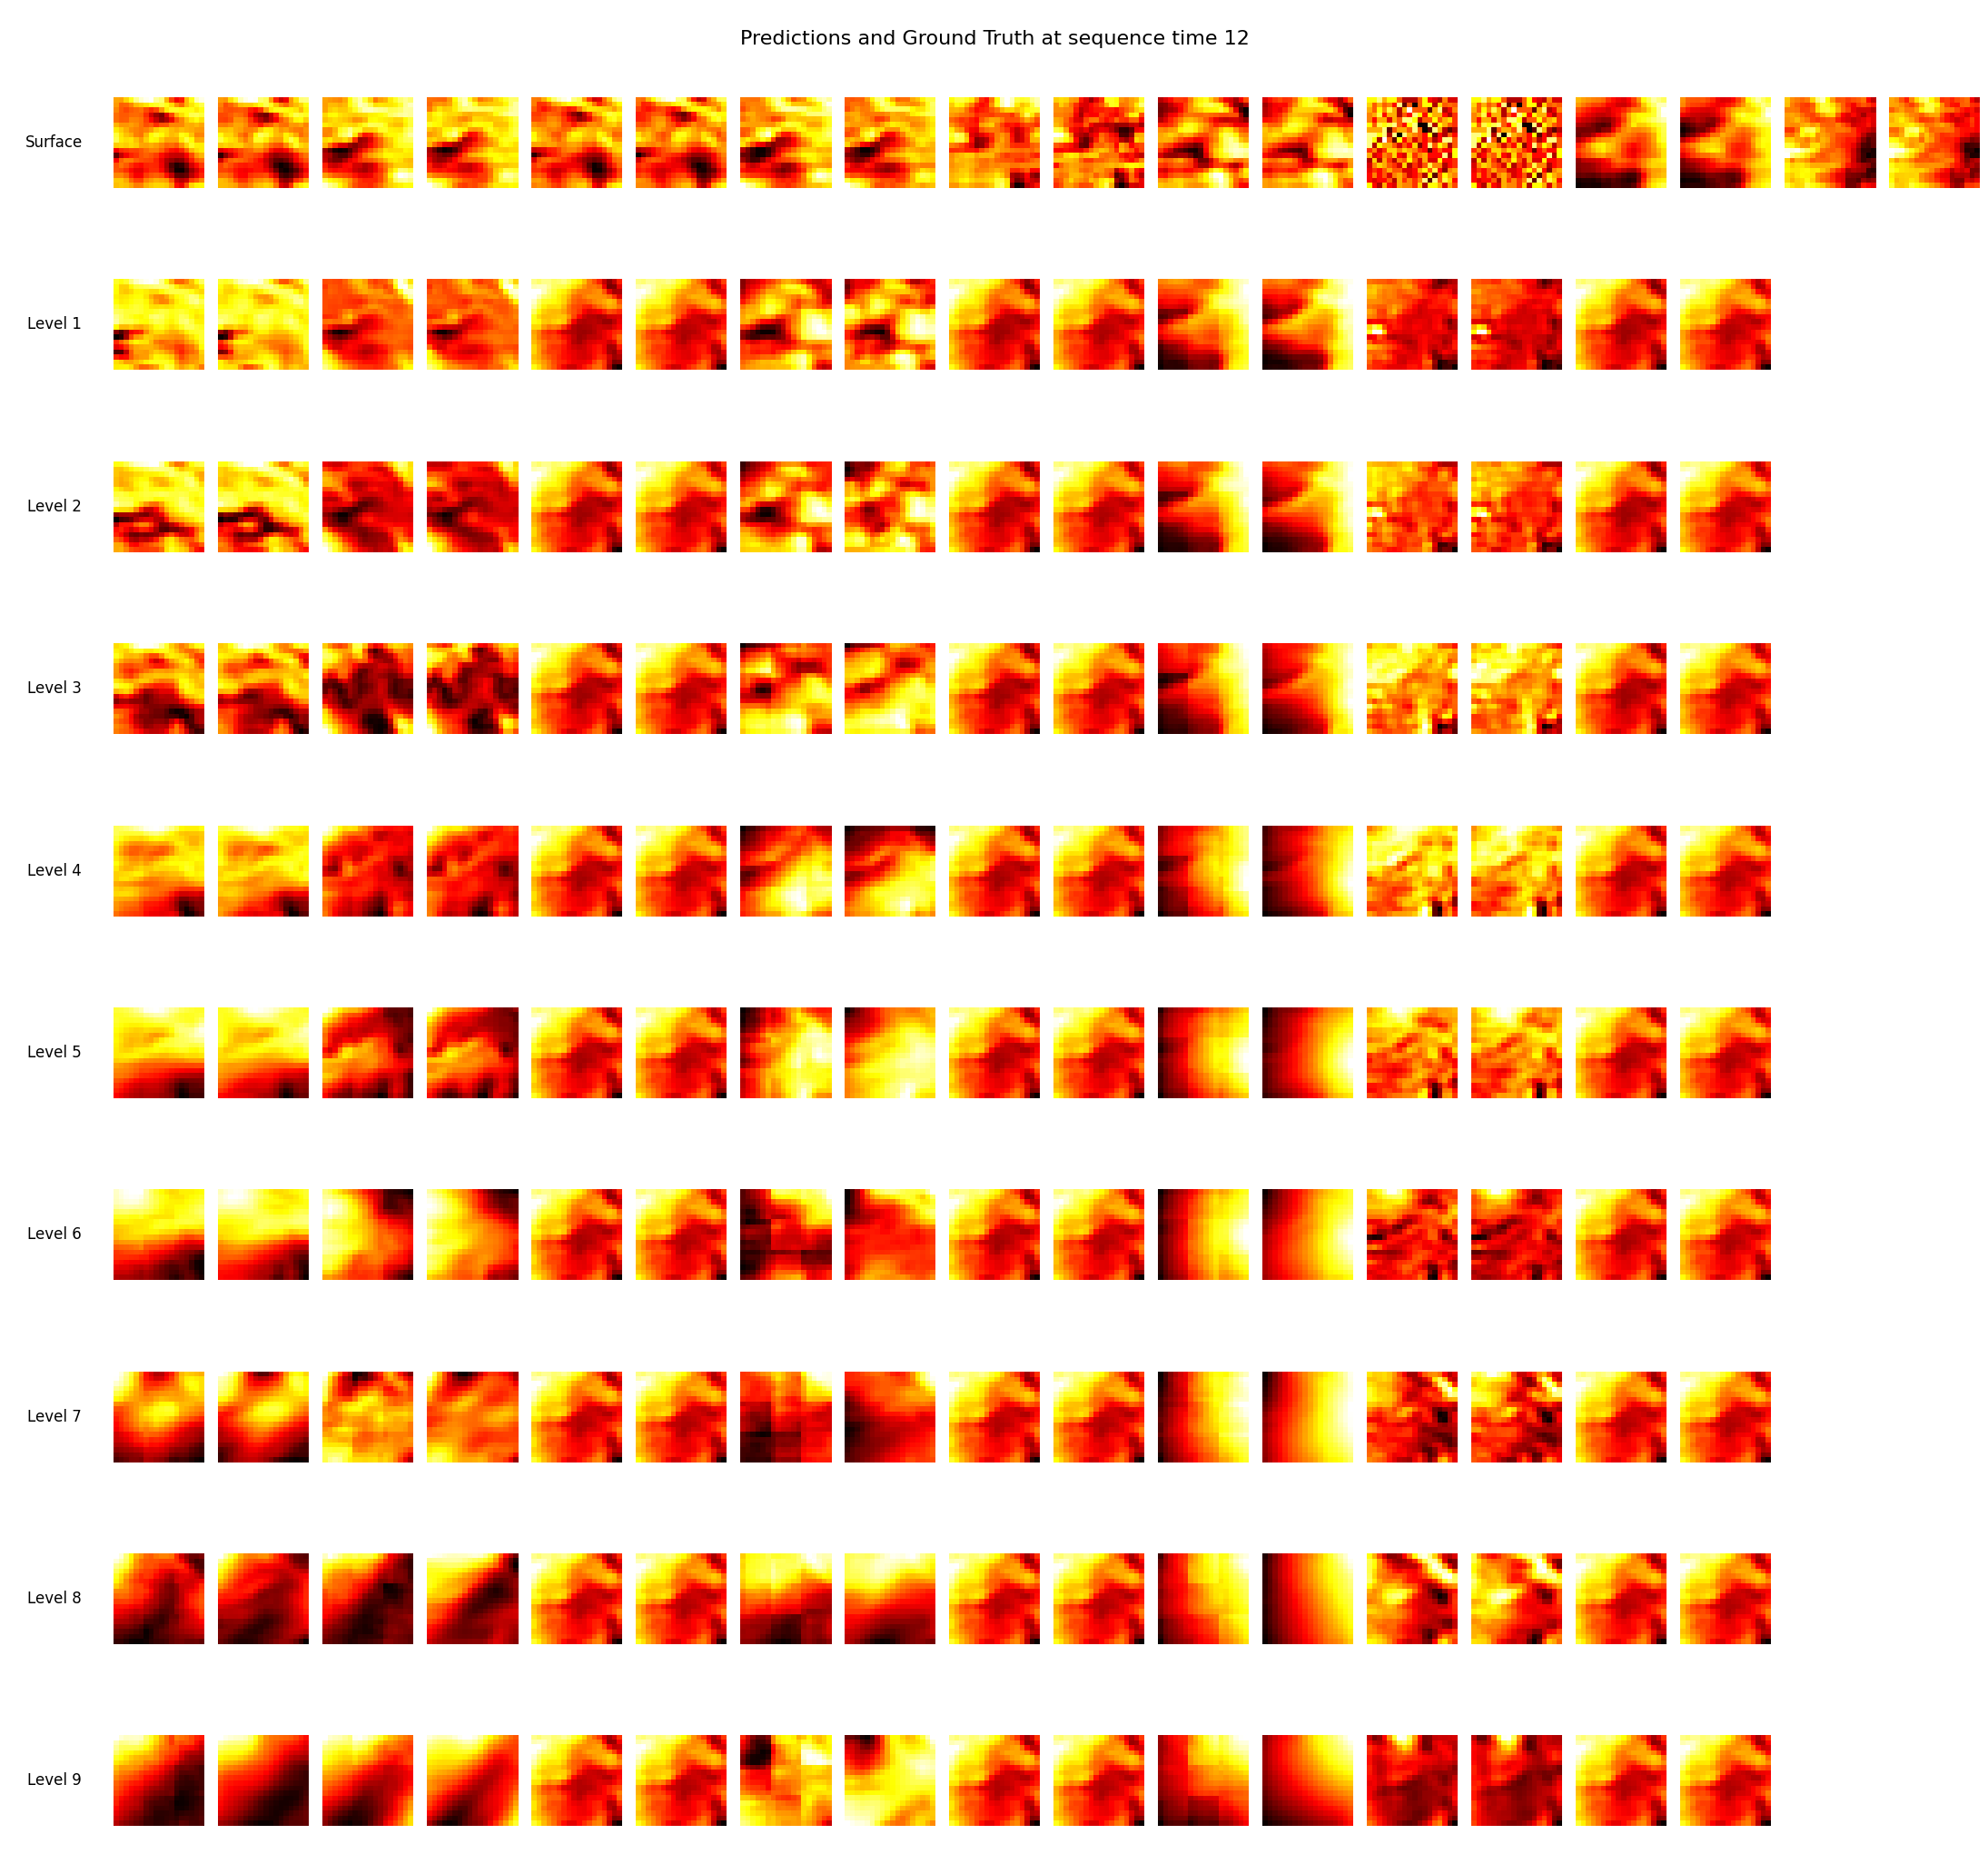

<Figure size 640x480 with 0 Axes>

In [14]:
fig = plot_heatmaps2(config, results, 11)
#wandb.log({"heatmap": fig})

In [ ]:
run.finish()

## Otros plots

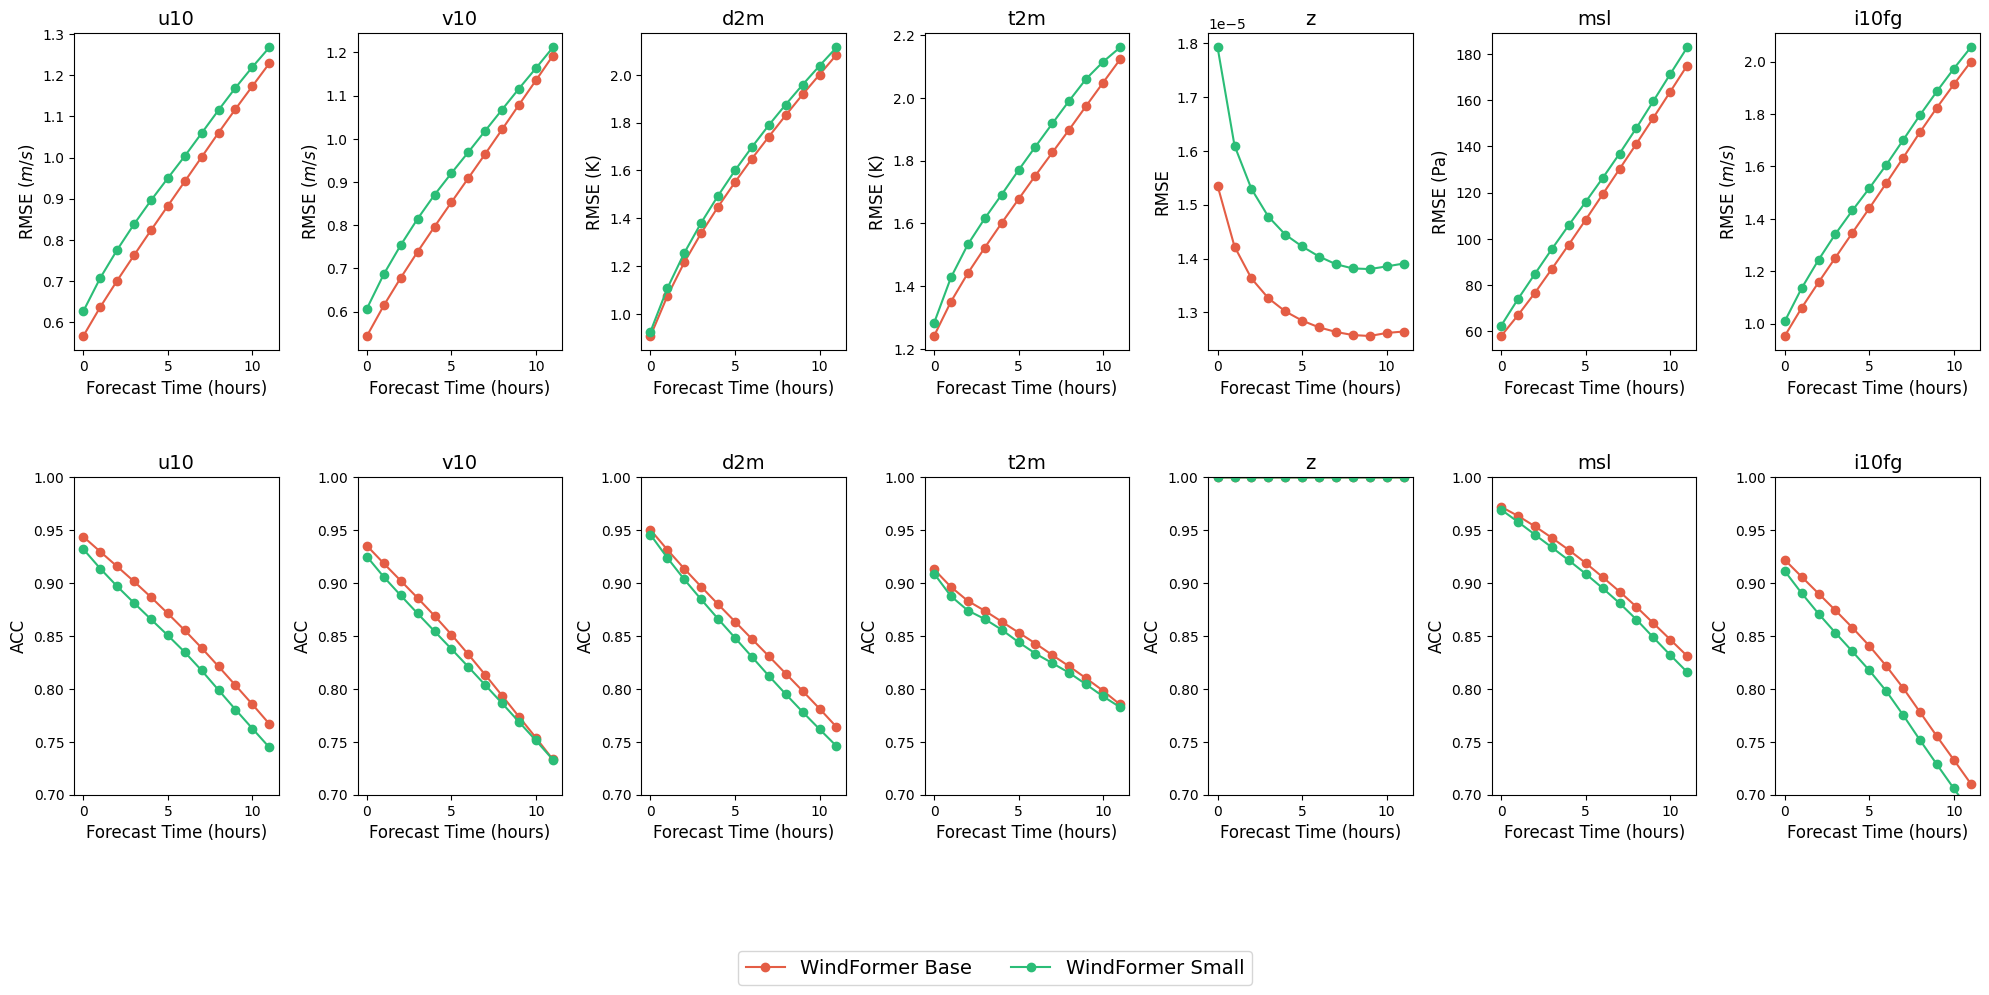

In [28]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Cargar los datos desde los archivos JSON
with open('/home/samuelr/projects/WindViViT/project/metrics-base.json') as f:
    data_base = json.load(f)

with open('/home/samuelr/projects/WindViViT/project/metrics-small.json') as f:
    data_small = json.load(f)

# Definir las variables de interés
variables = ['u10', 'v10', 'd2m', 't2m', 'z', 'msl', 'i10fg']

# Extraer los datos para las variables en superficie
def extract_data(data, variables):
    forecast_times = sorted(data.keys(), key=int)
    rmse = {var: [] for var in variables}
    acc = {var: [] for var in variables}

    for time in forecast_times:
        for var in variables:
            rmse[var].append(data[time]['surface_rmse'][var])
            acc[var].append(data[time]['surface_acc'][var])
    
    return np.array(forecast_times, dtype=int), rmse, acc

forecast_times, rmse_base, acc_base = extract_data(data_base, variables)
_, rmse_small, acc_small = extract_data(data_small, variables)

ylabels_rmse = ['RMSE ($m/s$)', 'RMSE ($m/s$)', 'RMSE (K)', 'RMSE (K)', 'RMSE ($m^2/s^2$)', 'RMSE (Pa)', 'RMSE ($m/s$)']
ylabels_acc = ['ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC']

fig, axes = plt.subplots(2, len(variables), figsize=(20, 10))  # Ajustar el tamaño de la figura

for i, var in enumerate(variables):
    # RMSE plots
    ax = axes[0, i]
    ax.plot(forecast_times, rmse_base[var], 'o-', color='#E45D45', label='WindFormer Base')
    ax.plot(forecast_times, rmse_small[var], 'o-', color='#2BBD77', label='WindFormer Small')
    ax.set_xlabel('Forecast Time (hours)', fontsize=12)
    ax.set_ylabel(ylabels_rmse[i], fontsize=12)
    ax.set_title(f'{var}', fontsize=14)

    # ACC plots
    ax = axes[1, i]
    ax.plot(forecast_times, acc_base[var], 'o-', color='#E45D45')
    ax.plot(forecast_times, acc_small[var], 'o-', color='#2BBD77')
    ax.set_xlabel('Forecast Time (hours)', fontsize=12)
    ax.set_ylabel(ylabels_acc[i], fontsize=12)
    ax.set_title(f'{var}', fontsize=14)
    ax.set_ylim(0.7, 1.0)  # Limitar el eje y entre 0.7 y 1.0
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Ajustar a dos decimales

# Agregar la leyenda al gráfico con un tamaño de fuente más grande
fig.legend(['WindFormer Base', 'WindFormer Small'], loc='lower center', ncol=2, fontsize=14)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, hspace=0.4)  # Aumentar espacio entre los subplots verticalmente
plt.show()

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

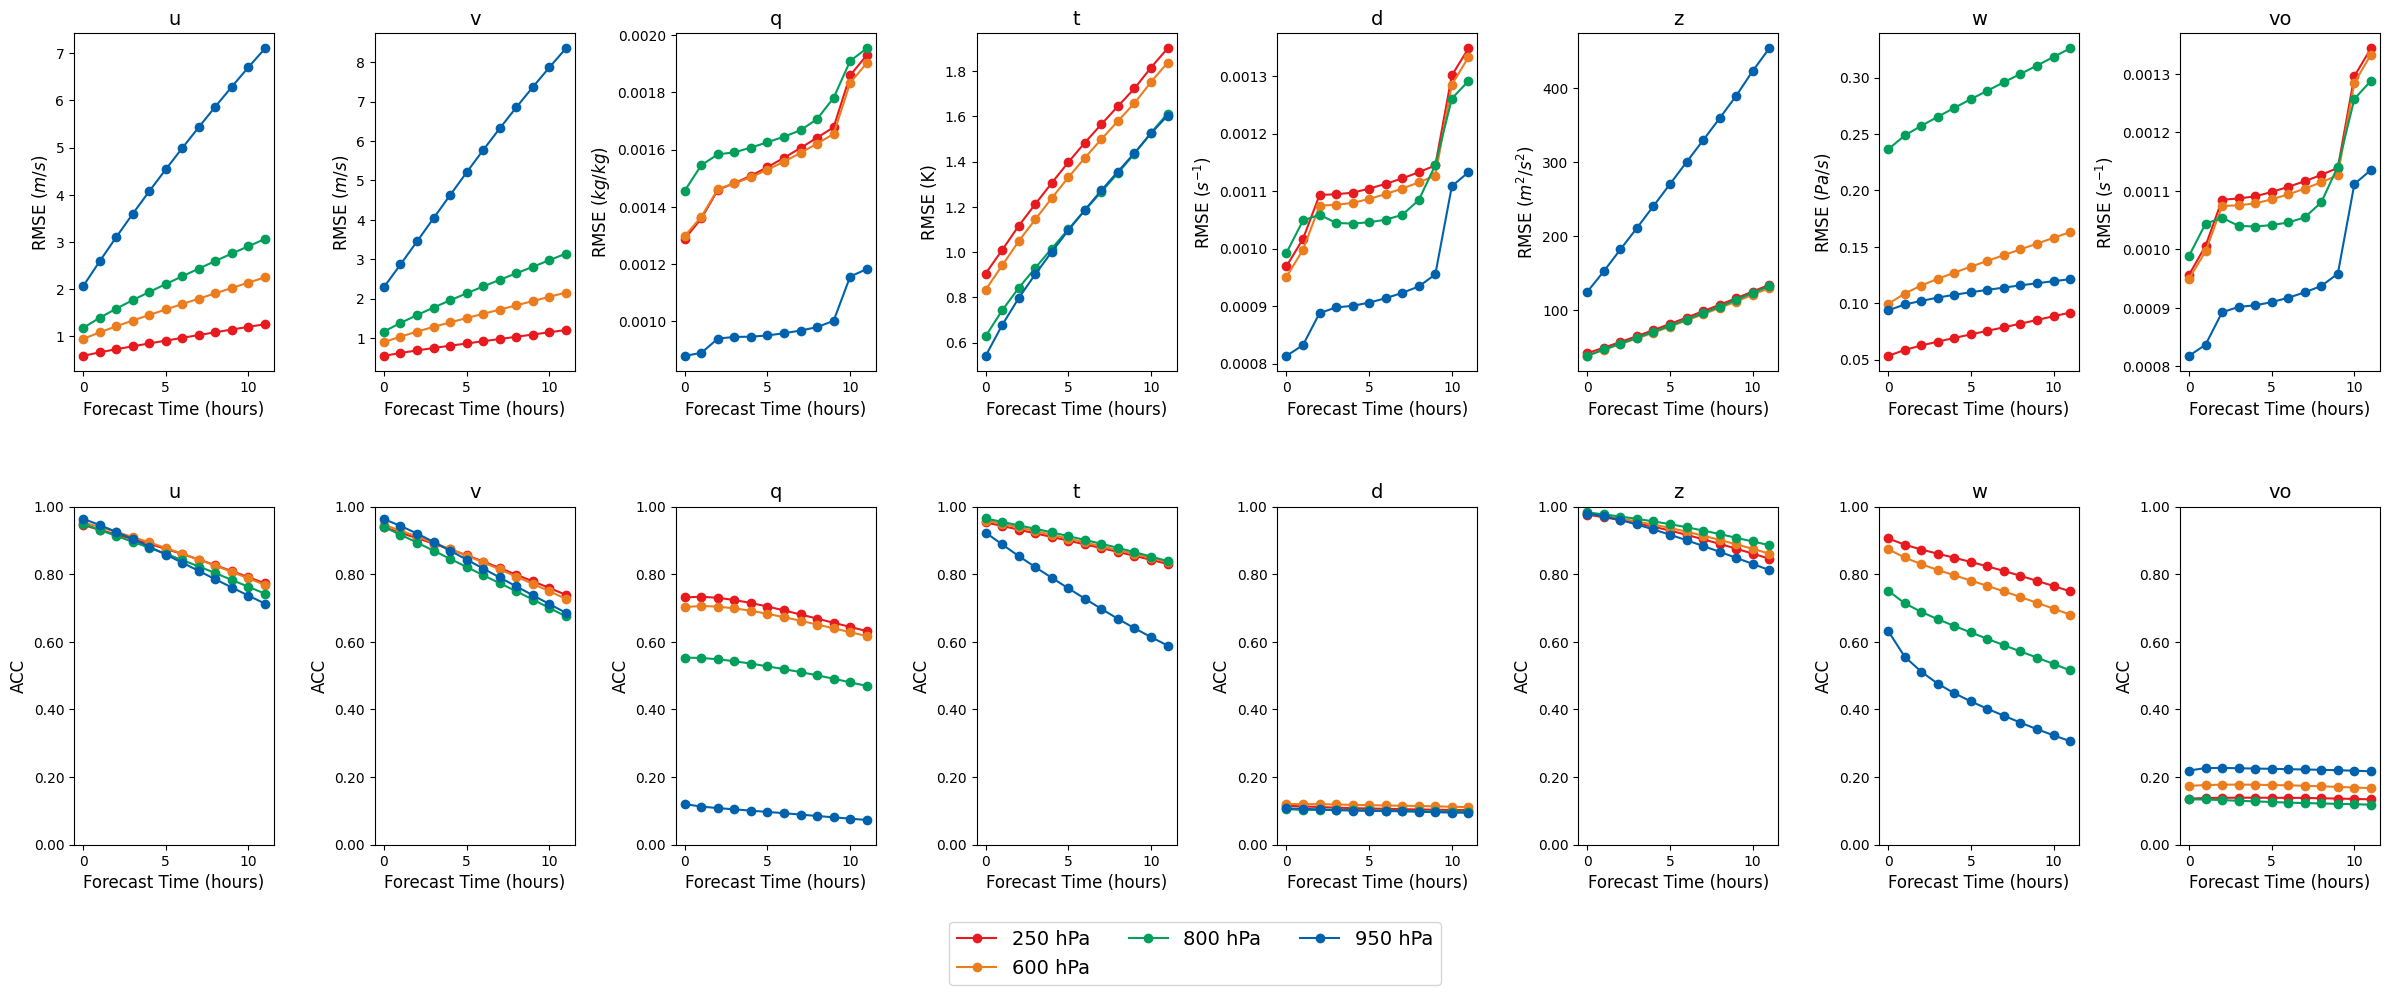

In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

# Cargar los datos desde los archivos JSON
with open('/home/samuelr/projects/WindViViT/project/metrics-base.json') as f:
    data_base = json.load(f)

# Definir las variables de interés y niveles de presión
variables = ['u', 'v', 'q', 't', 'd', 'z', 'w', 'vo']
pressure_levels = ['250', '600', '800', '950']
colors = ['#E61A1F', '#EB7D1E', '#009F5B', '#0062AC']  # Colores personalizados para los niveles de presión

# Extraer los datos para las variables en los diferentes niveles de presión
def extract_data(data, variables, levels):
    forecast_times = sorted(data.keys(), key=int)
    rmse = {var: {level: [] for level in levels} for var in variables}
    acc = {var: {level: [] for level in levels} for var in variables}

    for time in forecast_times:
        for var in variables:
            for level in levels:
                rmse[var][level].append(data[time]['upper_rmse'][var][level])
                acc[var][level].append(data[time]['upper_acc'][var][level])
    
    return np.array(forecast_times, dtype=int), rmse, acc

forecast_times, rmse_base, acc_base = extract_data(data_base, variables, pressure_levels)

ylabels_rmse = ['RMSE ($m/s$)', 'RMSE ($m/s$)', 'RMSE ($kg/kg$)', 'RMSE (K)', 'RMSE ($s^{-1}$)', 'RMSE ($m^2/s^2$)', 'RMSE ($Pa/s$)', 'RMSE ($s^{-1}$)']
ylabels_acc = ['ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC', 'ACC']

fig, axes = plt.subplots(2, len(variables), figsize=(24, 10))  # Ajustar el tamaño de la figura

for i, var in enumerate(variables):
    for j, level in enumerate(pressure_levels):
        color = colors[j]  # Asignar color según el nivel de presión
        # RMSE plots
        ax = axes[0, i]
        ax.plot(forecast_times, rmse_base[var][level], 'o-', color=color, label=f'{level} hPa')
        ax.set_xlabel('Forecast Time (hours)', fontsize=12)
        ax.set_ylabel(ylabels_rmse[i], fontsize=12)
        ax.set_title(f'{var}', fontsize=14)

        # ACC plots
        ax = axes[1, i]
        ax.plot(forecast_times, acc_base[var][level], 'o-', color=color, label=f'{level} hPa')
        ax.set_xlabel('Forecast Time (hours)', fontsize=12)
        ax.set_ylabel(ylabels_acc[i], fontsize=12)
        ax.set_title(f'{var}', fontsize=14)
        ax.set_ylim(0, 1.0)  # Limitar el eje y entre 0.7 y 1.0
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))  # Ajustar a dos decimales

# Agregar la leyenda fuera del bucle, para evitar repeticiones
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15, hspace=0.4)  # Aumentar espacio entre los subplots verticalmente
plt.show()
